## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=128
sz=32

In [4]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

Here is a benchmark with SGD (usually gives a result between 93.7% and 94% accuracy)

In [5]:
m = wrn_22()
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr = 0.5

In [6]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.132085   1.281381   0.5677    
    1      0.809292   0.865459   0.7012                      
    2      0.634346   0.660822   0.7757                      
    3      0.567303   0.611578   0.7882                      
    4      0.511911   0.598666   0.7935                      
    5      0.453896   0.554444   0.8164                      
    6      0.459425   0.584449   0.8079                      
    7      0.412847   0.414145   0.8558                      
    8      0.394785   0.550501   0.8246                      
    9      0.369612   0.430183   0.8594                      
    10     0.367298   0.552524   0.8167                      
    11     0.351999   0.773417   0.7883                      
    12     0.340457   0.367909   0.8754                      
    13     0.319416   0.682482   0.7775                      
    14     0.315152   0.435242   0.8565                      
    15     0.30741    0.528

[0.20161142144203187, 0.9429]

(Our findings on average: 94.18%)

Let's try Adam now. Tests with beta2 varying in 0.999, 0.99, 0.9 and 0.7 showed that 0.99 seems to be the best value.

In [6]:
m = wrn_22()
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))

In [7]:
learn.save('init')

First with L2 regularization

In [9]:
learn.lr_find(wds=wd)

 94%|█████████▍| 368/391 [00:39<00:02,  9.33it/s, loss=7]   

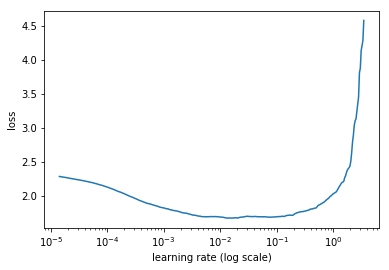

In [10]:
learn.sched.plot()

In [9]:
lr = 1e-3

We pick a learning rate where the loss is still improving. Extensive tests show that 1e-3 is the best value of lr to get the maximum accuracy.

In [10]:
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85))

 21%|██        | 83/391 [00:09<00:36,  8.50it/s, loss=1.84]
epoch      trn_loss   val_loss   accuracy                   
    0      1.209223   1.224005   0.5642    
    1      0.912271   0.978291   0.653                       
    2      0.745827   0.863427   0.7044                      
    3      0.641443   0.818068   0.7229                      
    4      0.58134    0.665084   0.7692                      
    5      0.506466   0.719583   0.7553                      
    6      0.461585   0.552324   0.8148                      
    7      0.42836    0.621516   0.7956                      
    8      0.417363   0.59709    0.8021                      
    9      0.39944    0.548987   0.8125                      
    10     0.381709   0.552056   0.8197                      
    11     0.352291   0.541899   0.8292                      
    12     0.362449   0.390104   0.8647                      
    13     0.352621   0.548704   0.8255                      
    14     0.308943   0.40621

[0.23713780753612518, 0.9359]

(Our findings on average: 93.49%)

In [11]:
val_l2 = learn.sched.val_losses
met_l2 = learn.sched.rec_metrics

Now let's do weight decay.

In [14]:
learn.load('init')
learn.lr_find(wds=wd, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      4.265609   10837.737577 0.1173    



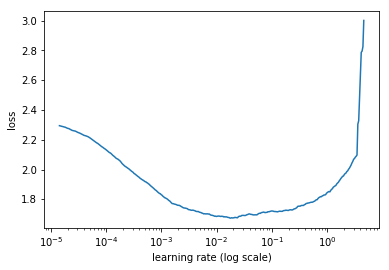

In [15]:
learn.sched.plot(10,20)

Here the best learning rate in our experiments is 3e-3.

In [14]:
lr=3e-3

In [15]:
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.114471   1.141272   0.6035    
    1      0.835948   0.846035   0.7002                      
    2      0.70201    0.744699   0.75                        
    3      0.594873   0.606664   0.7962                      
    4      0.522855   0.625445   0.7926                      
    5      0.468955   0.680878   0.7796                      
    6      0.437359   0.532818   0.8202                      
    7      0.40571    0.62247    0.8031                      
    8      0.37827    0.517      0.8306                      
    9      0.349524   0.429428   0.8569                      
    10     0.327598   0.453849   0.8563                      
    11     0.302648   0.350249   0.8859                      
    12     0.270317   0.495357   0.8445                      
    13     0.270328   0.494772   0.8471                      
    14     0.239715   0.338573   0.8881                      
    15     0.218043   0.369

[0.26916724123060703, 0.9398]

(Our findings on average: 94%) And here is the last bit of accuracy! We also get to 93% in 25 epochs when it took 30 for the L2 reg.

In [17]:
val_wd = learn.sched.val_losses
met_wd = learn.sched.rec_metrics

In [18]:
epochs = list(range(1,31))

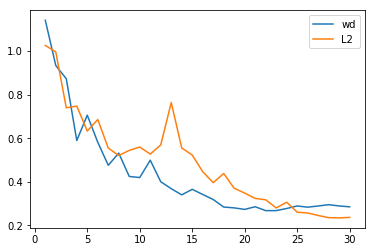

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(epochs, val_wd, label='wd')
ax.plot(epochs, val_l2, label='L2')
ax.legend(loc='upper right')

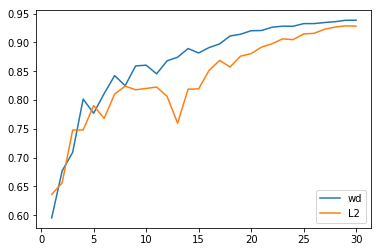

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(epochs, met_wd, label='wd')
ax.plot(epochs, met_l2, label='L2')
ax.legend(loc='lower right')

Now let's see how fast we can be to train the model to 94% accuracy.

In [19]:
learn.load('init')
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
%time learn.fit(lr, 1, wds=wd, cycle_len=18, use_clr_beta=(10,7.5,0.95,0.85), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.100212   1.107082   0.5965    
    1      0.837876   0.941279   0.6799                      
    2      0.682582   0.677779   0.7676                      
    3      0.603947   0.718723   0.7635                      
    4      0.536209   0.668456   0.7704                      
    5      0.462783   0.537996   0.8158                      
    6      0.443069   0.618013   0.7959                      
    7      0.406426   0.459833   0.8443                      
    8      0.363596   0.459676   0.8481                      
    9      0.308999   0.387687   0.8707                      
    10     0.254811   0.365728   0.8815                      
    11     0.20992    0.311081   0.8953                      
    12     0.165968   0.301685   0.9048                      
    13     0.141617   0.247372   0.9195                      
    14     0.11061    0.256815   0.9202                      
    15     0.077968   0.246

[0.24070589029788972, 0.9322]

In [20]:
def accuracy_with_TTA(learn):
    preds, targs = learn.TTA()
    probs = np.mean(np.exp(preds),0)
    return accuracy_np(probs, targs)

In [21]:
accuracy_with_TTA(learn)

0.9392

(and with a bit of luck you get to 94%)

# With amsgrad

To activate amsgrad, we just have to pass amsgrad=True to the optimizer.

In [32]:
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99), amsgrad=True)

In [33]:
learn.load('init')
%time learn.fit(1e-3, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.225979   1.299488   0.5321    
    1      0.937289   0.962883   0.6511                      
    2      0.733208   0.832843   0.7137                      
    3      0.630176   0.780865   0.729                       
    4      0.562199   0.595009   0.7941                      
    5      0.492363   0.585122   0.7965                      
    6      0.471037   0.621124   0.7891                      
    7      0.422223   0.486214   0.8341                      
    8      0.401842   0.542495   0.8248                      
    9      0.372675   0.403706   0.8644                      
    10     0.350397   0.435613   0.8484                      
    11     0.330725   0.470373   0.8437                      
    12     0.310322   0.454382   0.8441                      
    13     0.302822   0.386894   0.8711                      
    14     0.275275   0.34446    0.8867                      
    15     0.246374   0.317

[0.23286711130142213, 0.9342]

(Our findings on average: 93.36%) This is slightly below the training with L2 reg.

In [35]:
learn.load('init')
%time learn.fit(3e-3, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.093954   1.056      0.6147    
    1      0.8162     0.909985   0.6769                      
    2      0.671625   0.872115   0.7017                      
    3      0.580006   0.585453   0.7945                      
    4      0.5061     0.522762   0.8195                      
    5      0.450187   0.517454   0.8278                      
    6      0.409246   0.469816   0.8428                      
    7      0.377618   0.419576   0.8578                      
    8      0.340505   0.391217   0.8677                      
    9      0.306417   0.417701   0.8636                      
    10     0.279903   0.372138   0.8779                      
    11     0.261991   0.336245   0.8878                      
    12     0.263883   0.445708   0.8566                      
    13     0.222472   0.32966    0.8897                      
    14     0.221655   0.31933    0.8976                      
    15     0.180152   0.286

[0.27553789917230603, 0.9347]

(Our findings on average: 93.74%) Again, this is slightly below the training with weight decay.